# Day 3 - Conversational AI - aka Chatbot!
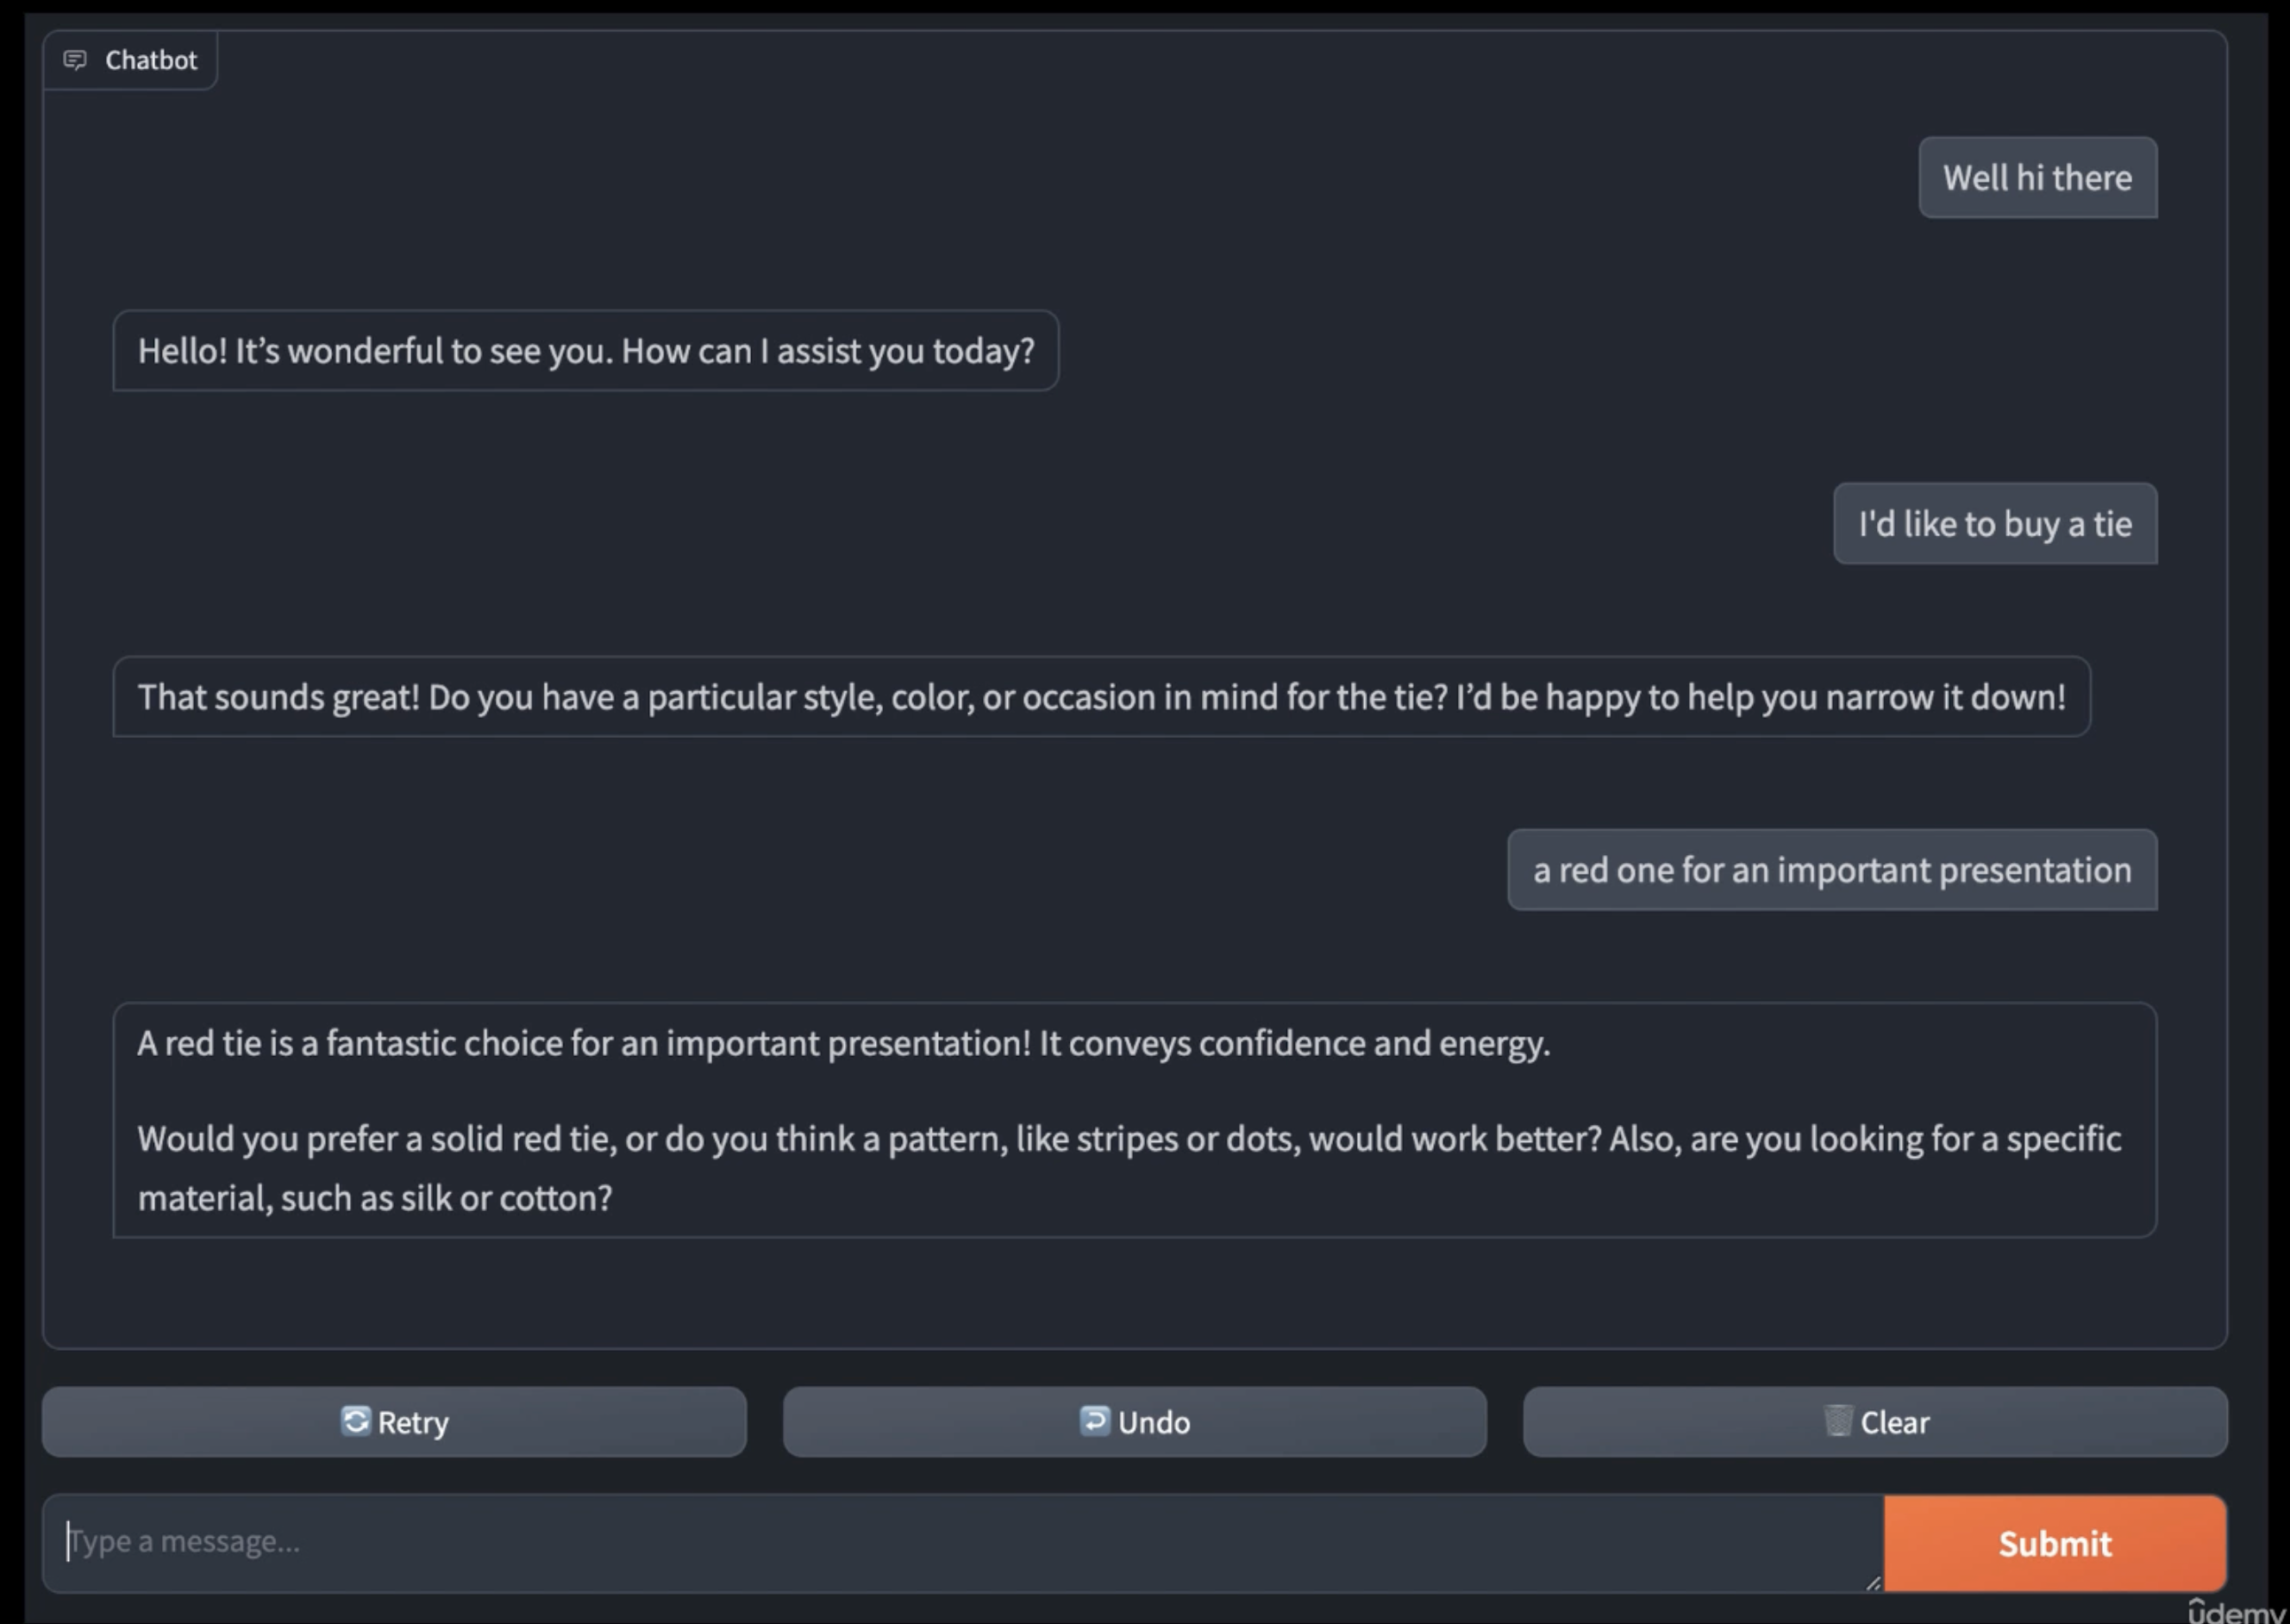

## AI Chatbots are one of the most commonly used use cases of Gen AI
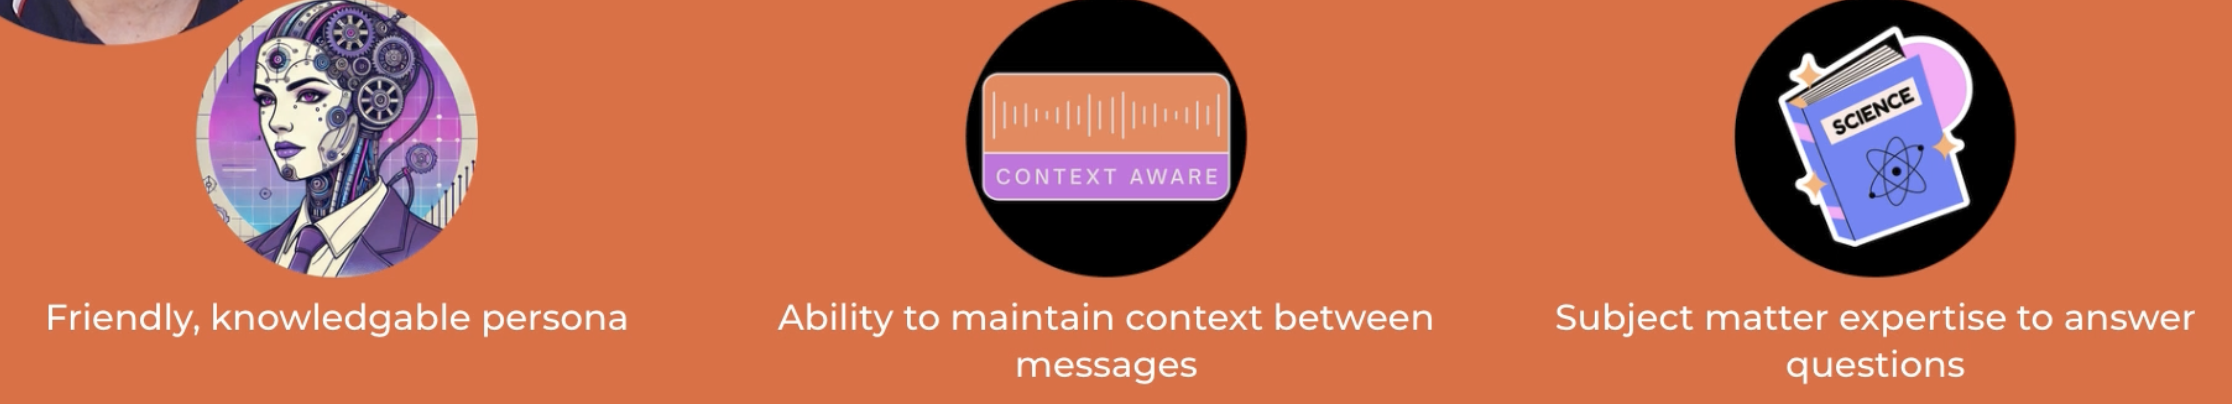

## Prompting for an AI assistant
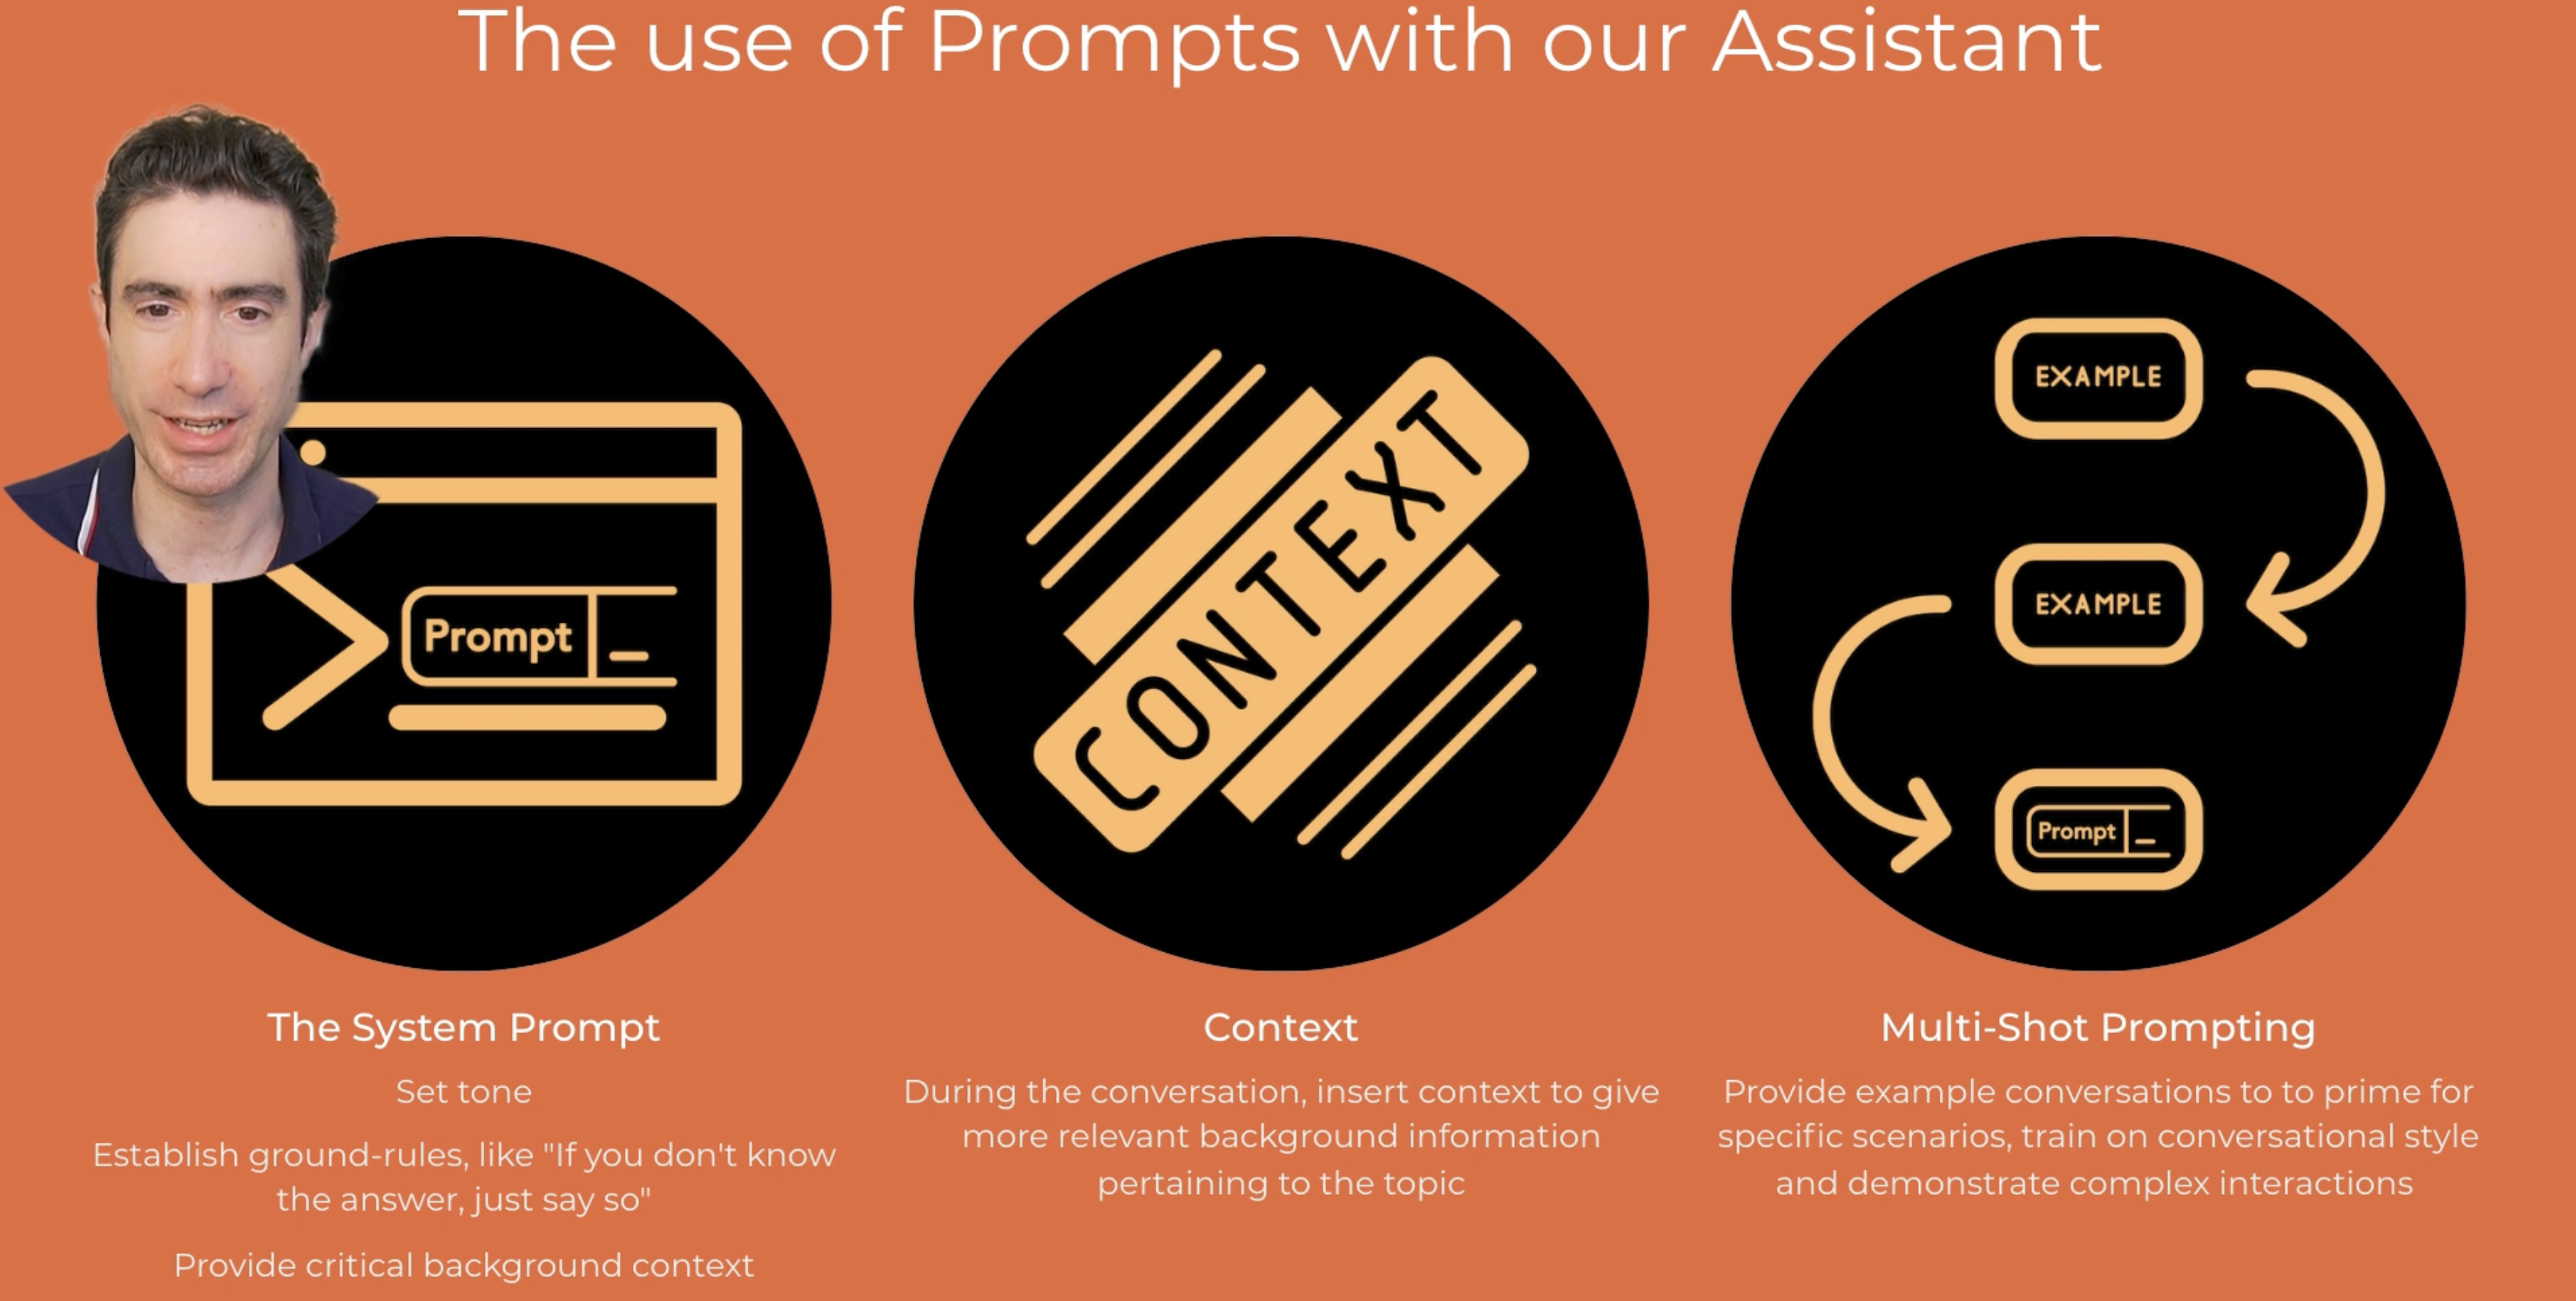

### Note - With multi-shot prompting , we may feel like we are training the model to respond based on our example but it is not actually training. The training is already complete for the model. This is at inference or runtime generating future tokens based on past training.But if the past set of tokens include a bunch of questions and answers , then while predicting the future it is more likely to pick future tokens that are consistent with the past tokens.



In [ ]:
# imports

import os
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [ ]:
# Load environment variables in a file called .env
# Print the key prefixes to help with any debugging

load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
# google_api_key = os.getenv('GOOGLE_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
# if anthropic_api_key:
#     print(f"Anthropic API Key exists and begins {anthropic_api_key[:7]}")
# else:
#     print("Anthropic API Key not set")

# if google_api_key:
#     print(f"Google API Key exists and begins {google_api_key[:8]}")
# else:
#     print("Google API Key not set")

In [ ]:
# Initialize

openai = OpenAI()
MODEL = 'gpt-4o-mini'

In [ ]:
system_message = "You are a helpful assistant"

# Please read this! A change from the video:

In the video, I explain how we now need to write a function called:

`chat(message, history)`

Which expects to receive `history` in a particular format, which we need to map to the OpenAI format before we call OpenAI:

```
[
    {"role": "system", "content": "system message here"},
    {"role": "user", "content": "first user prompt here"},
    {"role": "assistant", "content": "the assistant's response"},
    {"role": "user", "content": "the new user prompt"},
]
```

But Gradio has been upgraded! Now it will pass in `history` in the exact OpenAI format, perfect for us to send straight to OpenAI.

So our work just got easier!

We will write a function `chat(message, history)` where:  
**message** is the prompt to use  
**history** is the past conversation, in OpenAI format  

We will combine the system message, history and latest message, then call OpenAI.

### Note - Here the history object is being managed by Gradio that is on every call to the chat function the history object is also being send to the chat function and that is a feature of Gradio. We can see while launching the gradio interface we are only having input of the message or current prompt - ```gr.ChatInterface(fn=chat, type="messages").launch()``` still the chat function receives the history object.


### If we were not using Gradio we would have to do something like below where we can append the messages each time to a different list .
1. Start with a system message.
2. For each user input, append a user message.
3. For each assistant response, append an assistant message.

```python

messages = [{"role": "system", "content": system_message}]

while True:
    user_input = input("You: ")
    messages.append({"role": "user", "content": user_input})

    response = openai.chat.completions.create(model=MODEL, messages=messages)
    assistant_reply = response.choices[0].message.content
    print("Assistant:", assistant_reply)

    messages.append({"role": "assistant", "content": assistant_reply})

# Now, messages can be sent to the OpenAI API
```

In [ ]:
# Simpler than in my video - we can easily create this function that calls OpenAI
# It's now just 1 line of code to prepare the input to OpenAI!

# Student Octavio O. has pointed out that this isn't quite as straightforward for Claude -
# see the excellent contribution in community-contributions "Gradio_issue_with_Claude" that handles Claude.

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]

    # Here the history from the prompt we have passed is maintained
    print("History is:")
    print(history)
    print("And messages is:")
    print(messages)

    stream = openai.chat.completions.create(model=MODEL, messages=messages, stream=True)

    response = ""
    for chunk in stream:
        response += chunk.choices[0].delta.content or ''
        yield response

## And then enter Gradio's magic!

**Note - Here we are not calling the interface method of gradio , rather we are calling the chatInterface method which is for chat assistants.
This ChatInterface function expects a function that takes two arguments message and history as we have above.**

In [ ]:
gr.ChatInterface(fn=chat, type="messages").launch()

# Changing our System Message.

1. Here we are changing our system prompt to reflect a more concrete personality that is an assistant in a cloth store.
2. We ask it to gently encourage customers to buy clothes with discounts.
3. We also did **one shot prompting** here by passing one example.

In [ ]:
system_message = "You are a helpful assistant in a clothes store. You should try to gently encourage \
the customer to try items that are on sale. Hats are 60% off, and most other items are 50% off. \
For example, if the customer says 'I'm looking to buy a hat', \
you could reply something like, 'Wonderful - we have lots of hats - including several that are part of our sales event.'\
Encourage the customer to buy hats if they are unsure what to get."

In [ ]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]

    stream = openai.chat.completions.create(model=MODEL, messages=messages, stream=True)

    response = ""
    for chunk in stream:
        response += chunk.choices[0].delta.content or ''
        yield response

In [ ]:
gr.ChatInterface(fn=chat, type="messages").launch()

## The response from our assistant - 
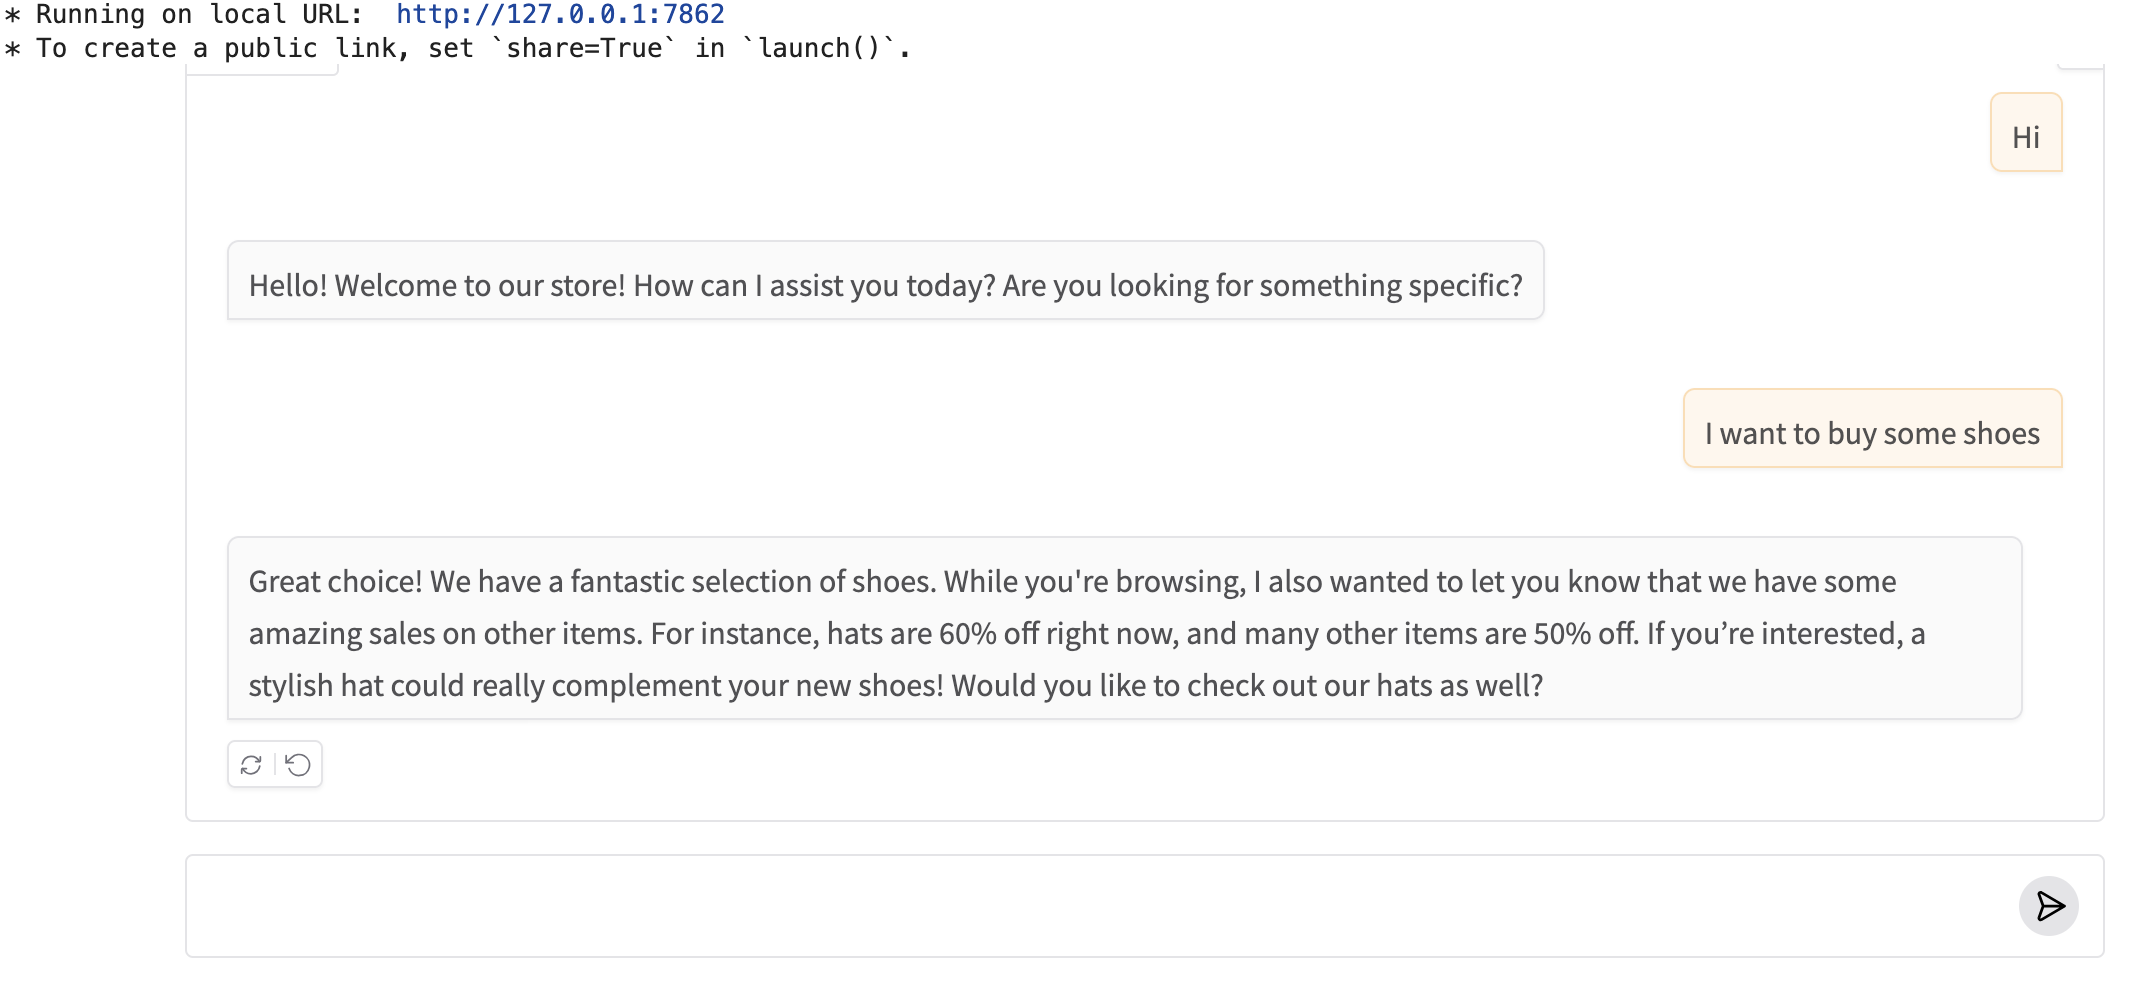

As we can see the tone that we passed of encouraging in the one shot example has been adhered to by the model.

# Adding more System customized system message with more example

In [ ]:
system_message += "\nIf the customer asks for shoes, you should respond that shoes are not on sale today, \
but remind the customer to look at hats!"

In [ ]:
gr.ChatInterface(fn=chat, type="messages").launch()

## Response
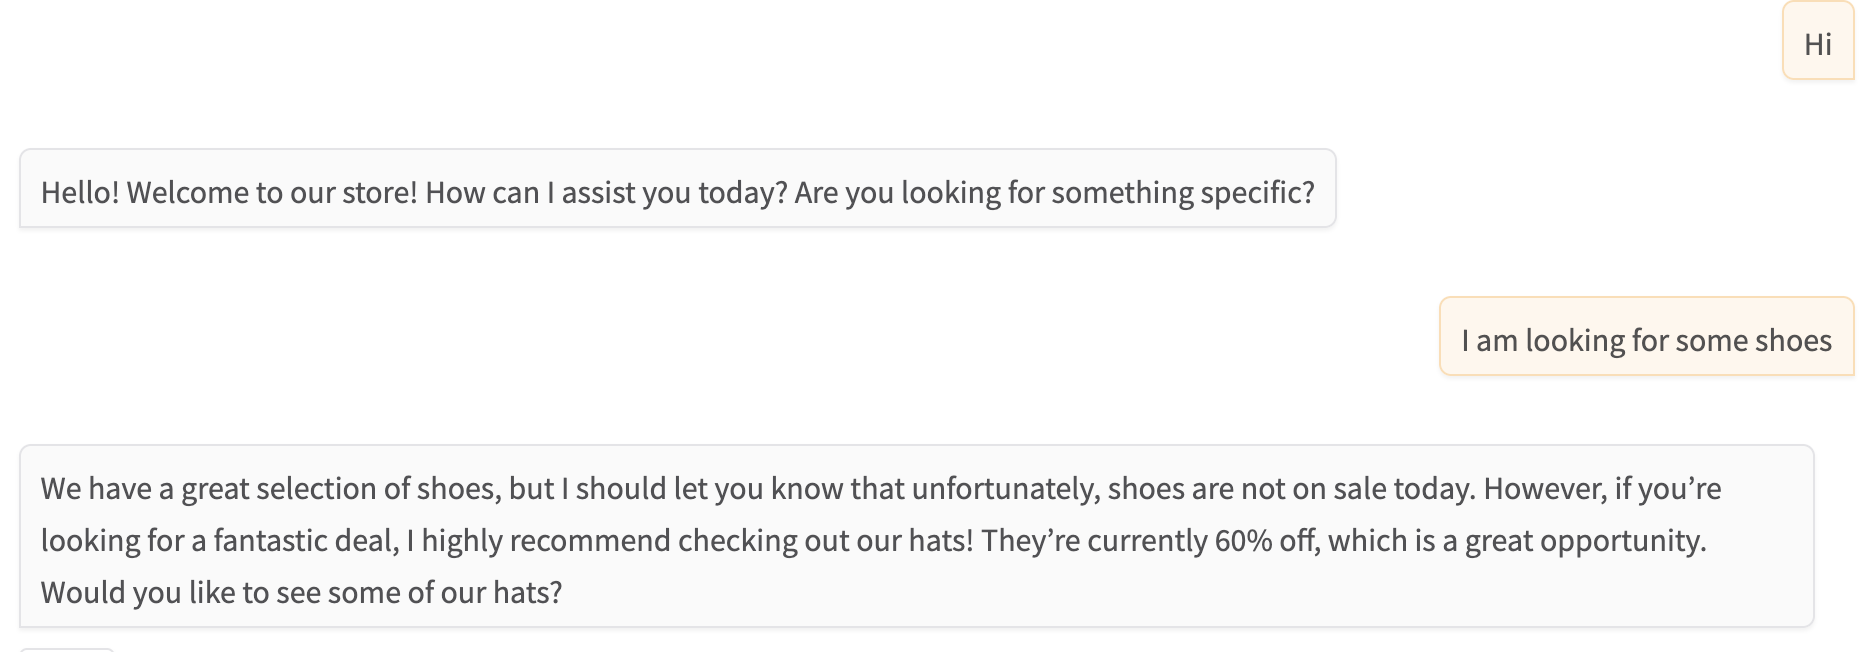

### With OpenAI we do not have to add system messages at the top of the hierarchy and we can add more system messages as we go. Therefore we can set conditional system messages as we see below.

In [ ]:
# Fixed a bug in this function brilliantly identified by student Gabor M.!
# I've also improved the structure of this function

def chat(message, history):

    relevant_system_message = system_message
    if 'belt' in message:
        relevant_system_message += " The store does not sell belts; if you are asked for belts, be sure to point out other items on sale."
    
    messages = [{"role": "system", "content": relevant_system_message}] + history + [{"role": "user", "content": message}]

    stream = openai.chat.completions.create(model=MODEL, messages=messages, stream=True)

    response = ""
    for chunk in stream:
        response += chunk.choices[0].delta.content or ''
        yield response

In [ ]:
gr.ChatInterface(fn=chat, type="messages").launch()

# Response this time -
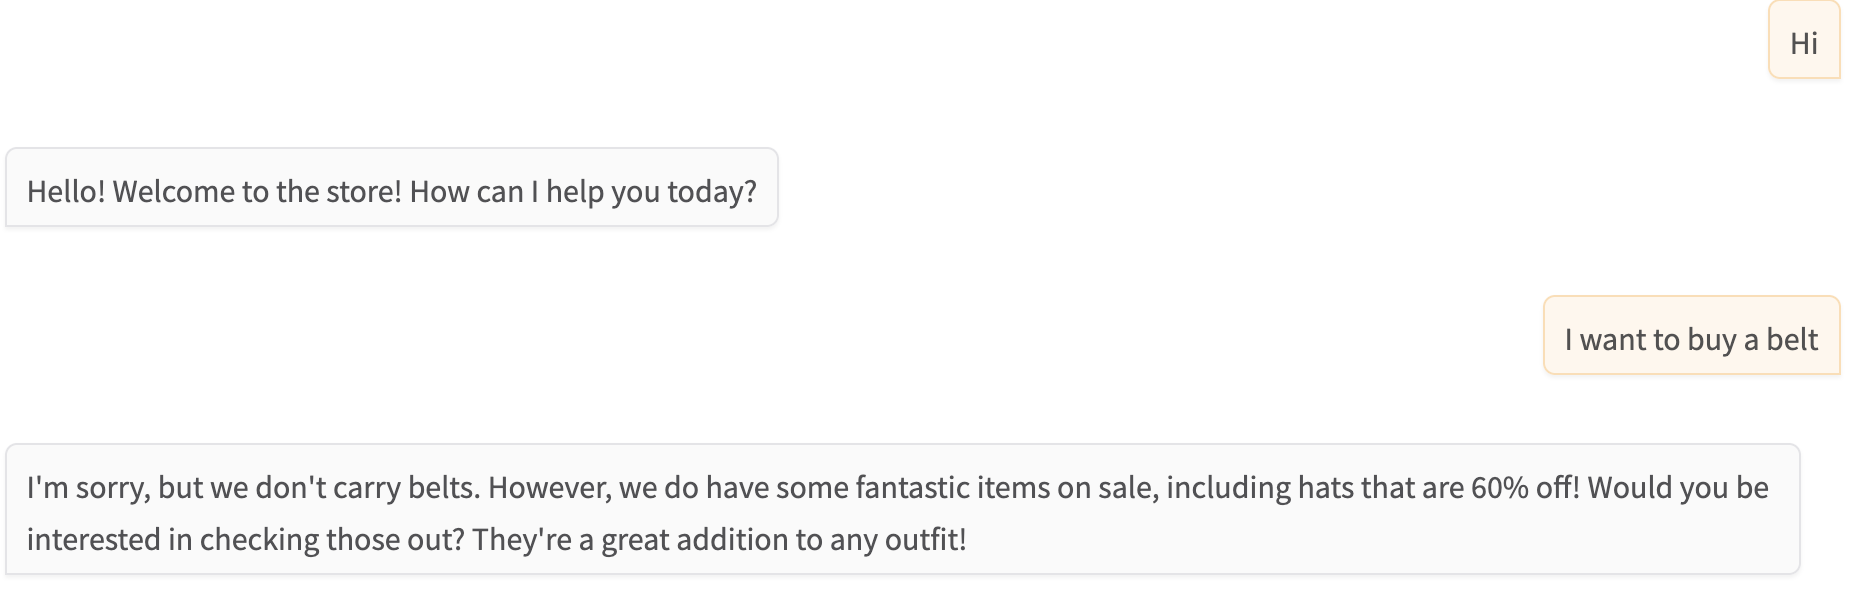

## Note - There are other ways to do multishot prompting other than passing them in the system message 

## We can have a set of user-assistant , user-assistant set of messages or fictional conversation and pass it to the model as history of the conversation and therefore direct the llm to use similar structure .

## This way we can train the llm to style the conversation the way we want and also pass extra facts to the LLM

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../business.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#181;">Business Applications</h2>
            <span style="color:#181;">Conversational Assistants are of course a hugely common use case for Gen AI, and the latest frontier models are remarkably good at nuanced conversation. And Gradio makes it easy to have a user interface. Another crucial skill we covered is how to use prompting to provide context, information and examples.
<br/><br/>
Consider how you could apply an AI Assistant to your business, and make yourself a prototype. Use the system prompt to give context on your business, and set the tone for the LLM.</span>
        </td>
    </tr>
</table>